<a href="https://colab.research.google.com/github/IpastorSan/GAN_neural_style_transfer/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First try to implement style transfer based on "A neural Algorithm of Artistic Style" https://arxiv.org/pdf/1508.06576.pdf

In [289]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19

In [237]:
content_image_path = "shanghai_content.jpg"
style_image_path = "dali_style.jpg"
result_prefix = "shanghai_ink"

In [238]:
#Weights of the different weight components (leap of faith)
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [239]:
#Dimensions of generated picture
#Generated picture: random image that will be optimized with respect to content and style image
width, height = tf.keras.preprocessing.image.load_img(content_image_path).size
img_nrows = 400
img_ncols = int(width*img_nrows / height)

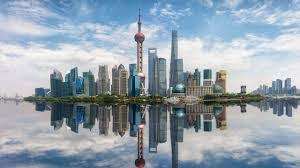

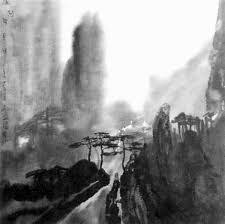

In [240]:
from IPython.display import Image, display
display(Image(content_image_path))
display(Image(style_image_path))

#1) Preprocessing

In [241]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    #The images are converted from RGB to BGR,\
    # then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
    img = vgg19.preprocess_input(img) 
    return tf.convert_to_tensor(img)

In [242]:
content_processed = preprocess_image(content_image_path)
style_processed = preprocess_image(style_image_path)

In [243]:
print(f"Content processed shape : {content_processed.shape}\nStyle processed shape {style_processed.shape}")

Content processed shape : (1, 400, 714, 3)
Style processed shape (1, 400, 714, 3)


In [244]:
def unprocess_image(img):
    #Transforms a tensor into a valid image
    img = tf.reshape(img,(img_nrows, img_ncols, 3))
    img = img.numpy()
    #remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

#2) Loss functions

We need a picture here, following the shape transformations of the gram matrix

In [245]:
def gram_matrix(x):
    #input is (1, Height, Width, C) ---> (H,W,C)
    x = tf.squeeze(x)
    x = tf.transpose(x, (2,0,1))   #shape (C,H,W)
    features = tf.reshape(x, (tf.shape(x)[0], -1))  #shape (C, H*W)
    gram = tf.matmul(features, tf.transpose(features)) #dot product of features and trnsposed of features (autocorrelation)
    return gram

In [246]:
def style_loss(style, combination):
    s = gram_matrix(style)
    c = gram_matrix(combination)
    channels = 3 
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(s-c)) / (4.0 * (channels ** 2) * (size**2)) #Look up this formula

In [247]:
def content_loss(content, combination):
    return tf.reduce_sum(tf.square(combination - content))

In [248]:
def total_loss(x):
    #this loss is intended to act as a regularization of high frequency vertical and horizontal artifacts of an image
    a = tf.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

#This formula is more explicit, but Tensorflow 2.0 has a direct implementation
#def total_loss(x):
#   x = tf.image.total_variation(x).numpy
#   return x

#2) Model

In [249]:
#Model with pre-trained Imagenet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

#Dictionary to get the output of each "key" layer
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

#Model that returns the activation of every layer in VGGG19 (as a dictionary)
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

#Nota Aqui hay margen para convertir las max pooling layers en average

In [250]:
#List of layers to use in the style loss (5, as per the paper)
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1",\
                     "block4_conv1", "block5_conv1"]

#Layer to use for the content loss
content_layer_name = "block5_conv2"

def compute_loss(combination_image, content_image, style_image):
    input_tensor = tf.concat([content_image, style_image, combination_image], axis=0)
    #content_image = axis 0 index 0, style_image = axis 0 index 1, combination_image = axis 0 index 2, 
    features = feature_extractor(inputs=input_tensor)
    
    #Initialize loss
    loss = tf.zeros(shape=())
    
    #Add content loss
    layer_features = features[content_layer_name] #extract layer by name
    content_image_features = layer_features[0, :, :, :] #gets all the weights up to block5_conv2, passed by the input of content image
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(content_image_features, combination_features)

    #add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    
    #add total variation loss
    loss += total_variation_weight * total_loss(combination_image)
    return loss


#3) Loss and gradient computation

In [251]:
@tf.function
def compute_loss_and_gradients(combination_image, content_image, style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, content_image, style_image)
    gradients = tape.gradient(loss, combination_image)
    return loss, gradients

#4)Training Loop

In [252]:
optimizer = tf.keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(\
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

content_image = preprocess_image(content_image_path)
style_image = preprocess_image((style_image_path))
combination_image = tf.Variable(preprocess_image(content_image_path)) #look into generating a random image

iterations = 4000
for i in range(1, iterations + 1):
    loss, gradients = compute_loss_and_gradients(combination_image, content_image, style_image)
    optimizer.apply_gradients([(gradients, combination_image)]) #investigar
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss}")
        img = unprocess_image(combination_image.numpy())
        fname = result_prefix +"_at_iteration_"+str(i)+".png"
        tf.keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=1188.102783203125
Iteration 200: loss=857.4117431640625
Iteration 300: loss=720.1883544921875
Iteration 400: loss=643.3675537109375
Iteration 500: loss=593.71923828125
Iteration 600: loss=558.5665283203125
Iteration 700: loss=532.1694946289062
Iteration 800: loss=511.39422607421875
Iteration 900: loss=494.53765869140625
Iteration 1000: loss=480.53851318359375
Iteration 1100: loss=468.716064453125
Iteration 1200: loss=458.5626220703125
Iteration 1300: loss=449.7716064453125
Iteration 1400: loss=442.1077880859375
Iteration 1500: loss=435.2869873046875
Iteration 1600: loss=429.2308349609375
Iteration 1700: loss=423.83935546875
Iteration 1800: loss=419.0108642578125
Iteration 1900: loss=414.6483154296875
Iteration 2000: loss=410.6997985839844
Iteration 2100: loss=407.09344482421875
Iteration 2200: loss=403.78216552734375
Iteration 2300: loss=400.72259521484375
Iteration 2400: loss=397.89697265625
Iteration 2500: loss=395.280029296875
Iteration 2600: loss=392.86218261718

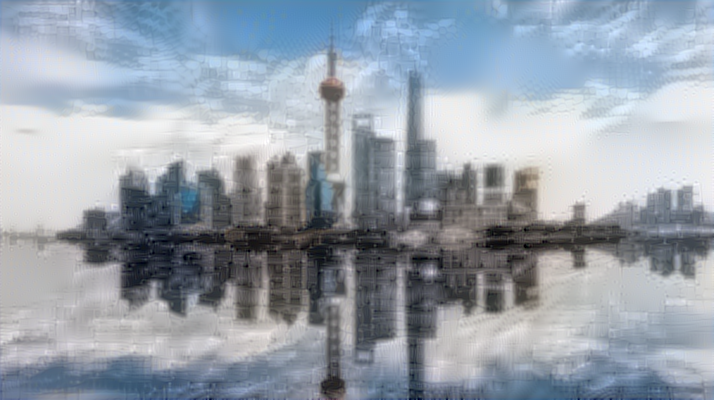

In [253]:
display(Image(fname))